# Optical Spectra Analysis

1. ALFOSC Spectra Redshift Confirmation
2. SDSS Spectra Redshift Confirmation
3. SDSS vs GMOS Balmer Decrement 

In [1]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
from __future__ import division
import sys
import os
import glob

#numpy
import numpy as np

#astropy
from astropy.io import ascii
from astropy.io import fits
from astropy.table import QTable
from astropy import wcs
from astropy.wcs import WCS
from astropy.modeling import models
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from astropy.coordinates import Galactic
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization.wcsaxes import Quadrangle
from astropy.coordinates import SkyCoord

from astropy.nddata import StdDevUncertainty, InverseVariance
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below

from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import snr
from specutils.analysis import line_flux

#spectral fitting
import pyspeckit

import h5py

#PIL
from PIL import Image

#matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.style as style
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Ellipse, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set1_4 as brewermap


#gifs
import imageio 

#pv stuff
from pvextractor import extract_pv_slice
from pvextractor import Path
from spectral_cube import SpectralCube
#import aplpy
from PyAstronomy import pyasl

#seaborn
import seaborn as sns

#pandas 
import pandas as pd

#pv stuff
from pvextractor import extract_pv_slice
from pvextractor import Path
from spectral_cube import SpectralCube
#import aplpy
from astropy.coordinates import SkyCoord
from PyAstronomy import pyasl
import pyregion
from pvextractor import PathFromCenter
from regions import Regions


#smoothing
from scipy.ndimage.filters import gaussian_filter

import importlib

# #warnings
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
fig_path = path_to_beads + 'Figures/paper/'

afile_path = 'Analysis/almaBeads/vcubes/'
xfile_path = 'Analysis/chandraBeads/wavelet_fit/'
gfile_path = 'Analysis/gmosBeads/'

In [4]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [5]:
importlib.reload(sf)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [6]:
#About my galaxy cluster
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

### 1. ALFOSC Spectra Redshift Confirmation

In [7]:
alfosc_path = path_to_beads + 'Analysis/optical_spectra/Nordic_Optical_Telescope_Spectrum/spec/'
alfosc_lower_file = alfosc_path  + 'lowerfinal_smoothed10.fits'
alfosc_upper_file = alfosc_path  + 'upperfinal_smooth10.fits'
alfosc_wav_file = alfosc_path  + 'outputwav.txt'


In [8]:
alfosc_lower = fits.open(alfosc_lower_file)[0]
alfosc_upper = fits.open(alfosc_upper_file)[0]
alfosc_wav = pd.read_csv(alfosc_wav_file, header=None, dtype=float)

In [9]:
spectral_line_dict = {
# abs'Ne IV': 2439.5,
#                      'Mg II': 2799.117,   ## Lines blueward of H-delta are just too blue for our wavelength coverage
#                      'Ne V': 3346.79,
#                      'Ne VI': 3426.85,
                     'O II 3727': 3727.092,
#                      'O II 3729': 3729.875,
#                      'He I': 3889.0,
#                      'S II 4072': 4072.3,
                     'Ca II K': 3933,
                     'Ca II H': 3969,
                     'Mg': 5175,
                     'Hgamma': 4341.68,
                     'Hbeta': 4862.68,
                     'OIII 4960': 4958.9,
                     'OIII 5007': 5006.84,
                      'OI 6300': 6300.3,
                      'NII 6583': 6583.45,
                      'NII 6548': 6548.05,
                      'SII 6717': 6716.44,
                      'SII 6730': 6730.81,
                      'Halpha': 6562.80,
                     }

Text(0.5, 0, 'Observed Wavelength ($\\dot{A}$)')

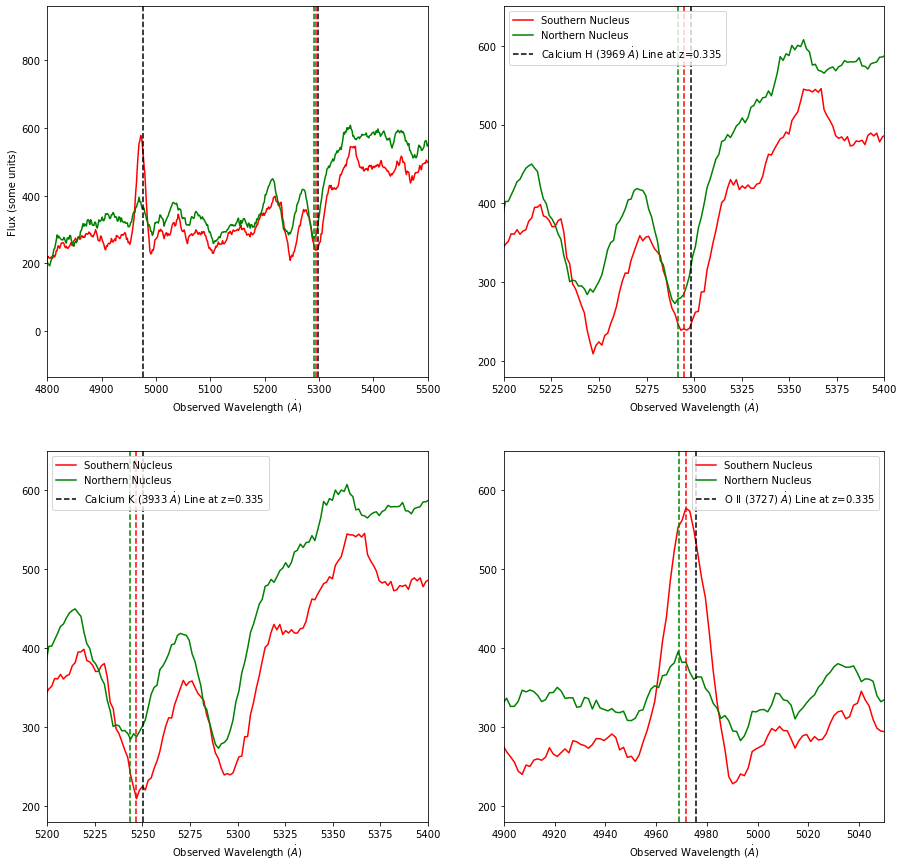

In [10]:
zn = 0.334
zs = 0.3332

fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs.ravel()

ax = axs[0][0]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(spectral_line_dict['Ca II H'] * 1.335, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
#ax.axvline(mg_obs, ls = '--', color='k', label = r'Mg (5175 $\dot{A}$) Line at z=0.335')
ax.axvline(spectral_line_dict['O II 3727'] * 1.335, ls = '--', color='k')
ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')
ax.set_xlim(4800, 5500)
#ax.set_xlim(5600, 8000)
# ax.set_ylim(180, 650)
ax.set_ylabel("Flux (some units)")
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

ax = axs[0][1]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(spectral_line_dict['Ca II H'] * 1.335, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')
ax.legend()
ax.set_xlim(5200, 5400)
ax.set_ylim(180, 650)
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

ax = axs[1][0]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(spectral_line_dict['Ca II K'] * 1.335, ls = '--', color='k', label = r'Calcium K (3933 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3933 * (1+zn), ls = '--', color='r')
ax.axvline(3933 * (1+zs), ls = '--', color='g')
ax.legend()
ax.set_xlim(5200, 5400)
ax.set_ylim(180, 650)
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

ax = axs[1][1]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(spectral_line_dict['O II 3727'] * 1.335, ls = '--', color='k', label = r'O II (3727) $\dot{A}$) Line at z=0.335')
ax.axvline(3727.092 * (1+zn), ls = '--', color='r')
ax.axvline(3727.092 * (1+zs), ls = '--', color='g')
ax.legend()
ax.set_xlim(4900, 5050)
ax.set_ylim(180, 650)
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

### 2. SDSS Spectra Redshift Confirmation

In [11]:
sdss_path = path_to_beads + 'Analysis/optical_spectra/'
sdss_spectrum_file = sdss_path + 'Nordic_Optical_Telescope_Spectrum/spec/sdss_smoothed.fits'

In [12]:
sdss_spectrum = fits.open(sdss_spectrum_file)[0]

In [13]:
sdss_hdr = sdss_spectrum.header

sdss_wave = []
#https://classic.sdss.org/dr3/products/spectra/read_spSpec.html

for pixel in range(sdss_hdr['NAXIS1']):
    sdss_wave_i = 10**(sdss_hdr['COEFF0'] + (sdss_hdr['COEFF1'] * (pixel))) #in vacuum units https://classic.sdss.org/dr3/products/spectra/vacwavelength.html
    sdss_wave_air_i = sdss_wave_i / (1.0 + 2.735182E-4 + 131.4182 / sdss_wave_i**2 + 2.76249E8 / sdss_wave_i**4)
    sdss_wave.append(sdss_wave_air_i)

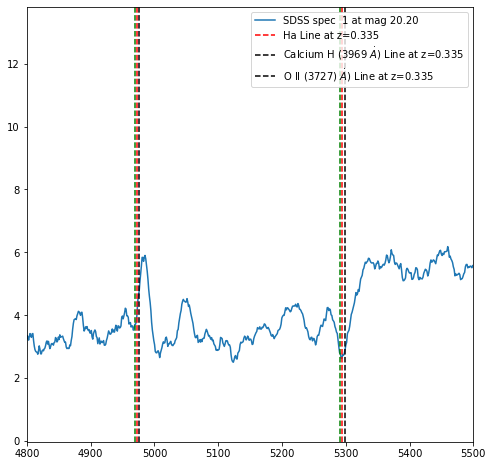

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sdss_wave , sdss_spectrum.data[0], label ='SDSS spec  1 at mag 20.20')
# ax.set_xlim(8600, 9000)
# ax.set_ylim(6,15)
ax.axvline(6562.80 * (1+0.335), ls = '--', color='r', label = 'Ha Line at z=0.335')

ax.axvline(spectral_line_dict['Ca II H'] * 1.335, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
ax.axvline(spectral_line_dict['O II 3727'] * 1.335, ls = '--', color='k', label = r'O II (3727) $\dot{A}$) Line at z=0.335')

ax.set_xlim(4800, 5500)

ax.axvline(3727.092 * (1+zn), ls = '--', color='r')
ax.axvline(3727.092 * (1+zs), ls = '--', color='g')

ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')

ax.legend()

### 3. SDSS vs GMOS Balmer Decrement 

#### SDSS

In [15]:
#open sdss spectra
f = fits.open('sdss_dr17_spectrum.fits')
specdata = f[1].data
f.close()

lamb = 10**specdata['loglam'] * u.AA  # don't use lambda as a variable name! it's a protected python word
flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 

inverse_variance = specdata['ivar']  # ivar is the inverse variance, see here: 
# wherever ivar is 0, this is a bad pixel
one_sigma_error = np.sqrt(1 / inverse_variance) * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
uncertainty = StdDevUncertainty(one_sigma_error)
model =  specdata['model'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 


spec = Spectrum1D(spectral_axis=lamb, flux=flux, redshift=0.335, uncertainty=uncertainty)


In [16]:
def filter_spectrum(xmin, xmax, xdata, ydata):
    filterx = np.where((xdata > xmin) & (xdata < xmax))
    return xdata[filterx], ydata[filterx]


Text(0.5, 0.98, 'SDSS')

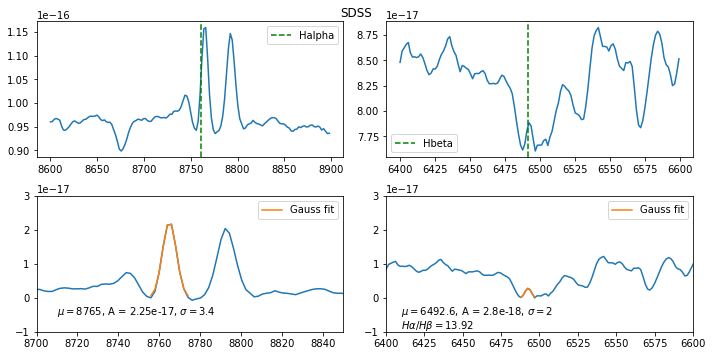

In [90]:
fig = plt.figure(figsize=(10,5), facecolor='white')
gs1 = GridSpec(2, 2)
#gs1.update(wspace=0.01)

#ax1: plot Ha spectrum area
ax1 = fig.add_subplot(gs1[0])
xdata, ydata = filter_spectrum(8600, 8900, lamb.value, model.value)
ax1.plot(xdata, ydata)
ax1.axvline(spectral_line_dict['Halpha'] * (1 + zh), ls='--', color='g', label = 'Halpha')
ax1.legend()

#ax2: plot Hb spectrum area
ax2 = fig.add_subplot(gs1[1])
xdata, ydata = filter_spectrum(6400, 6600, lamb.value, model.value)
ax2.plot(xdata, ydata)
ax2.axvline(spectral_line_dict['Hbeta'] * (1 + zh), ls='--', color='g', label = 'Hbeta')
ax2.legend()


#ax3: SDSS Halpha fit
xdata, ydata = filter_spectrum(8755, 8775, lamb.value, model.value)

ax3 = fig.add_subplot(gs1[2])

ax3.plot(lamb.value, model.value - min(ydata), '-')

mu, sigma, amp = 8765, 3.4, 2.25e-17
ax3.plot(xdata, sf.gauss(xdata, mu, sigma, amp), label='Gauss fit')

ax3.legend()
ax3.set_xlim(8700, 8850)
ax3.set_ylim(-1e-17, 3e-17)
ax3.text(8710, -0.5e-17, r'$\mu = {}$, A = {}, $\sigma = {}$'.format(mu, amp, sigma))

ha_integral = sf.gauss_integral(min(xdata), max(xdata),  mu=mu, sigma=sigma, amp=amp)

#ax4: SDSS Hbeta fit
xdata, ydata = filter_spectrum(6486.4, 6498.3, lamb.value, model.value)

ax4 = fig.add_subplot(gs1[3])

ax4.plot(lamb.value, model.value - min(ydata), '-')

mu, sigma, amp = 6492.6, 2, 2.8e-18
ax4.plot(xdata, sf.gauss(xdata, mu, sigma, amp), label='Gauss fit')

ax4.legend()
ax4.text(6410, -0.5e-17, r'$\mu = {}$, A = {}, $\sigma = {}$'.format(mu, amp, sigma))

hb_integral = sf.gauss_integral(min(xdata), max(xdata),  mu=mu, sigma=sigma, amp=amp)

ax4.set_xlim(6400, 6600)
ax4.set_ylim(-1e-17, 3e-17)

ax4.text(6410, -0.9e-17, r'$H\alpha/H\beta = {:.2f}$'.format(ha_integral[0]/hb_integral[0]))


fig.tight_layout()
fig.suptitle(r'SDSS')

In [91]:
hb_integral

(1.3667842977836501e-17, 4.602800036613179e-27)

#### GMOS

In [47]:
fov = path_to_beads + 'Analysis/gmosBeads/reduced/SDSSJ1531+3414.acube.fits'
hdu, header, w = pf.open_fits(fov, naxis=2)
num_spectral_elements = np.shape(hdu.data.T)[2]

In [48]:
#open Gmos Spectra

gmos_nbeads_file = path_to_beads + 'Analysis/gmosBeads/osase/qfitsview/regions/nbeads.fits'
gmos_sbeads_file = path_to_beads + 'Analysis/gmosBeads/osase/qfitsview/regions/sbeads.fits'

gmos_nbeads = fits.open(gmos_nbeads_file)[0].data
gmos_sbeads = fits.open(gmos_sbeads_file)[0].data

#load cube for wavelength axis
fov = path_to_beads + 'Analysis/gmosBeads/reduced/SDSSJ1531+3414.acube.fits'
hdu, header, w = pf.open_fits(fov, naxis=2)
num_spectral_elements = np.shape(hdu.data.T)[2]
gmos_wav =  (np.arange(num_spectral_elements) - (header['CRPIX3'] - 1)) * header['CDELT3'] + header['CRVAL3']


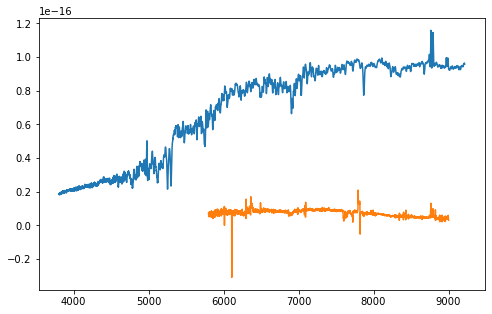

In [49]:
#SDSSS vss GMOS Spectra

plt.figure(figsize=(8,5))
plt.plot(lamb.value, model.value, '-', label='SDSS')
plt.plot(gmos_wav, gmos_nbeads * 1e-16, '-', label='GMOS')

Text(0.5, 1.05, 'GMOS North, z=0.335')

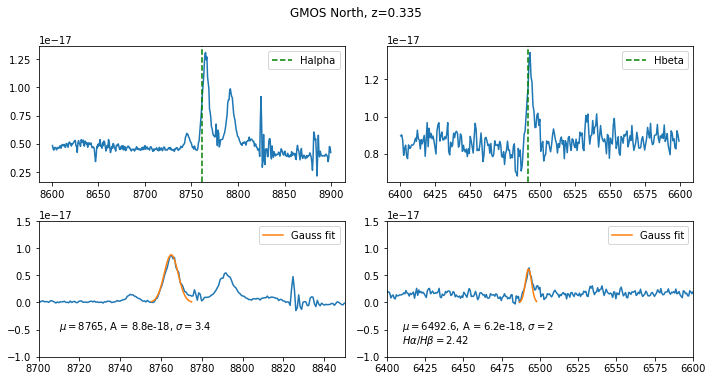

In [101]:
fig = plt.figure(figsize=(10,5), facecolor='white')
gs1 = GridSpec(2, 2)
#gs1.update(wspace=0.01)

#ax1: plot Ha area
ax1 = fig.add_subplot(gs1[0])
xdata, ydata = filter_spectrum(8600, 8900, gmos_wav, gmos_nbeads * 1e-16)
ax1.plot(xdata, ydata)
ax1.axvline(spectral_line_dict['Halpha'] * (1 + zh), ls='--', color='g', label = 'Halpha')
ax1.legend()

#ax2: plot Hb area
ax2 = fig.add_subplot(gs1[1])
xdata, ydata = filter_spectrum(6400, 6600, gmos_wav, gmos_nbeads * 1e-16)
ax2.plot(xdata, ydata)
ax2.axvline(spectral_line_dict['Hbeta'] * (1 + zh), ls='--', color='g', label = 'Hbeta')
ax2.legend()

#ax3: GMOS Halpha fit
xdata, ydata = filter_spectrum(8755, 8775, gmos_wav, gmos_nbeads * 1e-16)

ax3 = fig.add_subplot(gs1[2])

ax3.plot(gmos_wav, gmos_nbeads * 1e-16 - min(ydata), '-')
mu, sigma, amp = 8765, 3.4, 0.088e-16
ha_integral = sf.gauss_integral(min(xdata), max(xdata),  mu=mu, sigma=sigma, amp=amp)
ax3.plot(xdata, sf.gauss(xdata, mu, sigma, amp), label='Gauss fit')

ax3.legend()
ax3.set_xlim(8700, 8850)
ax3.set_ylim(-1e-17, 1.5e-17)
ax3.text(8710, -0.5e-17, r'$\mu = {}$, A = {}, $\sigma = {}$'.format(mu, amp, sigma))


#ax4: GMOS Hbeta fit
xdata, ydata = filter_spectrum(6486.4, 6498.3, gmos_wav, gmos_nbeads * 1e-16)

ax4 = fig.add_subplot(gs1[3])

ax4.plot(gmos_wav, gmos_nbeads * 1e-16 - min(ydata), '-')
mu, sigma, amp = 6492.6, 2, 6.2e-18
ax4.plot(xdata, sf.gauss(xdata, mu, sigma, amp), label='Gauss fit')

ax4.legend()
ax4.text(6410, -0.5e-17, r'$\mu = {}$, A = {}, $\sigma = {}$'.format(mu, amp, sigma))
hb_integral = sf.gauss_integral(min(xdata), max(xdata),  mu=mu, sigma=sigma, amp=amp)

ax4.set_xlim(6400, 6600)
ax4.set_ylim(-1e-17, 1.5e-17)

ax4.text(6410, -0.75e-17, r'$H\alpha/H\beta = {:.2f}$'.format(ha_integral[0]/hb_integral[0]))


fig.tight_layout()
fig.suptitle(r'GMOS North, z=0.335', y=1.05)

Text(0.5, 1.05, 'GMOS South')

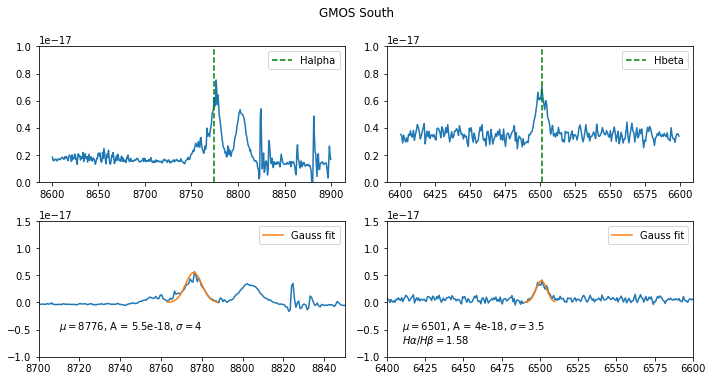

In [100]:
fig = plt.figure(figsize=(10,5), facecolor='white')
gs1 = GridSpec(2, 2)
#gs1.update(wspace=0.01)

zs = 0.337
#ax1: plot Ha area
ax1 = fig.add_subplot(gs1[0])
xdata, ydata = filter_spectrum(8600, 8900, gmos_wav, gmos_sbeads * 1e-16)
ax1.plot(xdata, ydata)
ax1.axvline(spectral_line_dict['Halpha'] * (1 + zs), ls='--', color='g', label = 'Halpha')
ax1.legend()
ax1.set_ylim(0, 1e-17)

#ax2: plot Hb area
ax2 = fig.add_subplot(gs1[1])
xdata, ydata = filter_spectrum(6400, 6600, gmos_wav, gmos_sbeads * 1e-16)
ax2.plot(xdata, ydata)
ax2.axvline(spectral_line_dict['Hbeta'] * (1 + zs), ls='--', color='g', label = 'Hbeta')
ax2.legend()
ax2.set_ylim(0, 1e-17)

#ax3: GMOS Halpha fit
xdata, ydata = filter_spectrum(8763, 8788, gmos_wav, gmos_sbeads * 1e-16)

ax3 = fig.add_subplot(gs1[2])

ax3.plot(gmos_wav, gmos_sbeads * 1e-16 - min(ydata), '-')
mu, sigma, amp = 8776, 4, 5.5e-18
ha_integral = sf.gauss_integral(min(xdata), max(xdata),  mu=mu, sigma=sigma, amp=amp)
ax3.plot(xdata, sf.gauss(xdata, mu, sigma, amp), label='Gauss fit')

ax3.legend()
ax3.set_xlim(8700, 8850)
ax3.set_ylim(-1e-17, 1.5e-17)
ax3.text(8710, -0.5e-17, r'$\mu = {}$, A = {}, $\sigma = {}$'.format(mu, amp, sigma))


#ax4: GMOS Hbeta fit
xdata, ydata = filter_spectrum(6490, 6510, gmos_wav, gmos_sbeads * 1e-16)

ax4 = fig.add_subplot(gs1[3])

ax4.plot(gmos_wav, gmos_sbeads * 1e-16 - min(ydata), '-')
mu, sigma, amp = 6501, 3.5, 4e-18
ax4.plot(xdata, sf.gauss(xdata, mu, sigma, amp), label='Gauss fit')

ax4.legend()
ax4.text(6410, -0.5e-17, r'$\mu = {}$, A = {}, $\sigma = {}$'.format(mu, amp, sigma))
hb_integral = sf.gauss_integral(min(xdata), max(xdata),  mu=mu, sigma=sigma, amp=amp)

ax4.set_xlim(6400, 6600)
ax4.set_ylim(-1e-17, 1.5e-17)

ax4.text(6410, -0.75e-17, r'$H\alpha/H\beta = {:.2f}$'.format(ha_integral[0]/hb_integral[0]))


fig.tight_layout()
fig.suptitle(r'GMOS South, z=0.337', y=1.05)


### 3b. what is the balmer decrememnt derived in tremblay 14

In [86]:
def ratio_obs(ebv):
    k_alpha = 2.63
    k_beta = 3.71
    ratio_intrinsic = 2.86
    return ratio_intrinsic * 10**(ebv * (k_beta-k_alpha)/2.5)

In [87]:
ebv = 0.023
t14_ratio = ratio_obs(ebv)

In [92]:
t14_ratio

2.926186707338955

In [88]:
t14_hb = 6.335e-16/t14_ratio

In [89]:
t14_hb

2.1649336264537223e-16

## Ignore

In [119]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=8765, sigma=3.4, amp=2.25e-17)
print(integral)

(1.9030717157992867e-16, 8.960300895304808e-24)


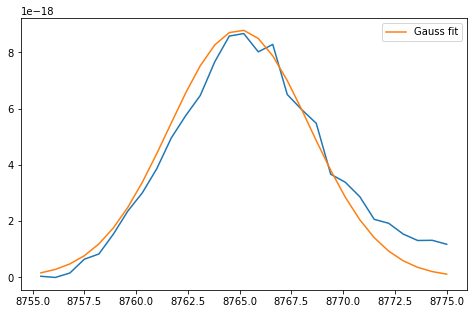

In [67]:
#GMOS Halpha
xdata, ydata = filter_spectrum(8755, 8775, gmos_wav, gmos_nbeads * 1e-16)

# # Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata - min(ydata), '-')
plt.plot(xdata, sf.gauss(xdata, 8765, 3.4, 0.088e-16), label='Gauss fit')
plt.legend()

In [68]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=8765, sigma=3.4, amp=0.088e-16)
print(integral)

(7.469759389215147e-17, 2.3994529152385367e-23)


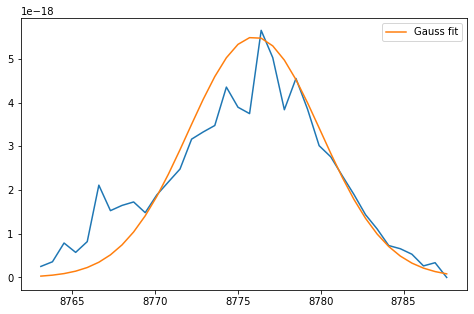

In [65]:
#GMOS Halpha
xdata, ydata = filter_spectrum(8763, 8788, gmos_wav, gmos_sbeads * 1e-16)

# # Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata - min(ydata), '-')
plt.plot(xdata, sf.gauss(xdata, 8776, 4, 5.5e-18), label='Gauss fit')
plt.legend()

In [66]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=8776, sigma=4, amp=5.5e-18)
print(integral)

(5.500819590173341e-17, 5.888945605385211e-23)


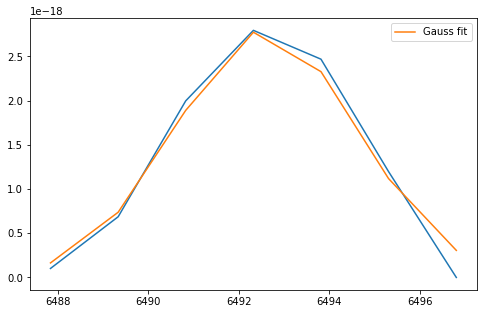

In [161]:
#SDSS hbeta
xdata, ydata = filter_spectrum(6486.4, 6498.3, lamb.value, model.value)

# # Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata - min(ydata), '-')
plt.plot(xdata, sf.gauss(xdata, 6492.6, 2, 2.8e-18), label='Gauss fit')
plt.legend()

In [162]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=6492.6, sigma=2, amp=2.8e-18)
print(integral)

(1.3667842977836501e-17, 4.602800036613179e-27)


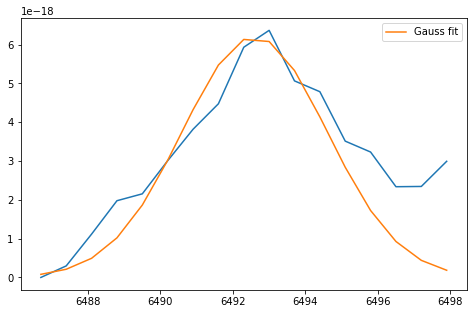

In [166]:
#GMOS hbeta
xdata, ydata = filter_spectrum(6486.4, 6498.3, gmos_wav, gmos_nbeads * 1e-16)

# # Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata - min(ydata), '-')
plt.plot(xdata, sf.gauss(xdata, 6492.6, 2, 6.2e-18), label='Gauss fit')
plt.legend()

In [167]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=6492.6, sigma=2, amp=6.2e-18)
print(integral)

(3.090771202798661e-17, 3.5841657592782486e-24)


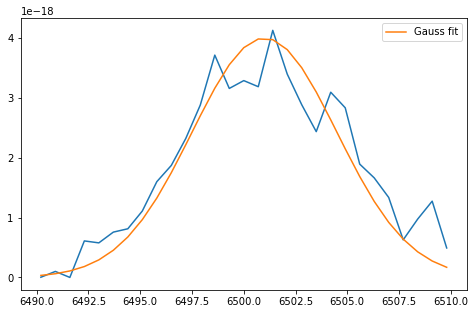

In [190]:
#GMOS hbeta
xdata, ydata = filter_spectrum(6490, 6510, gmos_wav, gmos_sbeads * 1e-16)

# # Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata - min(ydata), '-')
plt.plot(xdata, sf.gauss(xdata, 6501, 3.5, 4e-18), label='Gauss fit')
plt.legend()

In [196]:
6562 * 1.337

8773.394

In [195]:
6501/4861


1.3373791400946307

In [191]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=6501, sigma=3.5, amp=4e-18)
print(integral)

(3.4847882966695973e-17, 1.2573426961314069e-24)


In [204]:
(7.47 + 5.5)/(3.09 + 3.48)

1.9741248097412478

In [165]:
7.5/3.09

2.4271844660194177

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


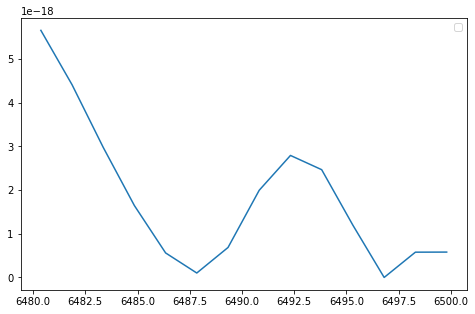

In [98]:
#hbeta
xdata, ydata = filter_spectrum(6480, 6500, lamb.value, model.value)

# # Fit the data using a Gaussian
# g_init = models.Gaussian1D(amplitude=1.15, mean=8765, stddev=3.)
# fit_g = fitting.LevMarLSQFitter()
# g = fit_g(g_init, xdata, ydata)

# # Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata - min(ydata), '-')
#plt.plot(xdata, sf.gauss(xdata, 6492.6, 2, 2.8e-18), label='Gauss fit')
plt.legend()

In [93]:
integral = sf.gauss_integral(min(xdata), max(xdata),  mu=6492.6, sigma=2, amp=2.8e-18)
print(integral)

(1.3667842977836501e-17, 4.602800036613179e-27)


In [94]:
1.9030717157992867e-16/1.3667842977836501e-17

13.92371655780118

In [77]:
def ratio_obs(ebv):
    k_alpha = 2.63
    k_beta = 3.71
    ratio_intrinsic = 2.86
    return ratio_intrinsic * 10**(ebv * (k_beta-k_alpha)/2.5)

In [78]:
ratio_obs(0.023)

2.926186707338955

In [95]:
6.335e-16/2.92

2.1695205479452057e-16

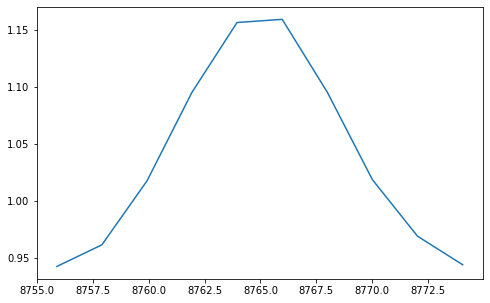

In [125]:
# Generate fake data
# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
# t_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5,
#                             bounds={"x_0": (-5., 5.)})
# fit_t = fitting.LevMarLSQFitter()
# t = fit_t(t_init, x, y)

xdata, ydata = filter_spectrum(8755, 8775, lamb.value, model.value/1e-16)

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1.15, mean=8765, stddev=3.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xdata, ydata)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(xdata, ydata, '-')
# plt.plot(x, t(x), label='Trapezoid')
#plt.plot(x, g(x), label='Gaussian')
# plt.xlabel('Position')
# plt.ylabel('Flux')
# plt.legend(loc=2)

In [11]:
0.65/0.25

2.6

In [43]:
specdata['loglam']

array([3.5803, 3.5804, 3.5805, ..., 3.9643, 3.9644, 3.9645], dtype=float32)

In [50]:
model

<Quantity [1.8601649e-17, 1.8799754e-17, 1.8808340e-17, ..., 9.6501292e-17,
           9.5948438e-17, 9.5819967e-17] erg / (Angstrom cm2 s)>

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


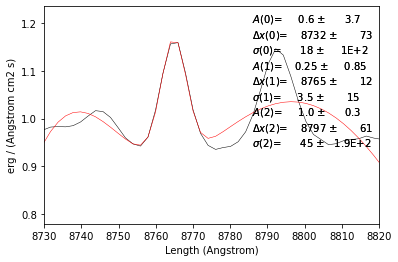

In [11]:
#try interactive fitting
sp = pyspeckit.Spectrum(xarr=spec.spectral_axis, data=model/1e-16)#, xarrkwargs={'unit':units[0]}, unit=units[1])
sp.plotter(xmin=8730, xmax=8820, linestyle='-')
guesses = [1.05, 8742, 1, 1.2, 8765, 3, 1.15, 8791, 3]
sp.specfit(fittype='gaussian', guesses=guesses, color='r')
# sp.plotter(linestyle='dashed', color='g')
# # sp.baseline(subtract=False)
# sp.specfit(fittype='gaussian', negamp=False, guesses=guesses, color='k')

In [13]:
integral = sp.specfit.integral(direct=True)

ValueError: Spectral axis is not linear to within 1e-08.  cdelt is not well-defined.

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


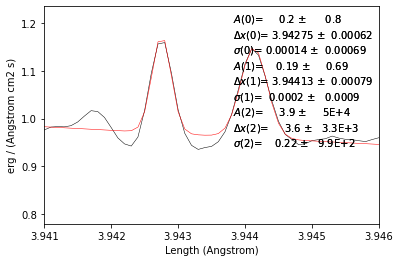

In [63]:
#halpha fit

sp = pyspeckit.Spectrum(xarr=specdata['loglam'] * u.AA, data=model/1e-16, cdelt=0.1)#, xarrkwargs={'unit':units[0]}, unit=units[1])
sp.plotter(linestyle='-', xmin=3.941, xmax=3.946)
guesses = [1.05, 3.9417, 0.01, 1.2, 3.9428, 0.02, 1.15, 3.944, 0.05]
sp.specfit(fittype='gaussian', guesses=guesses, color='r')
# sp.plotter(linestyle='dashed', color='g')
# # sp.baseline(subtract=False)
# sp.specfit(fittype='gaussian', negamp=False, guesses=guesses, color='k')

In [153]:
(sp.xarr.max() - sp.xarr.min())/sp.xarr.min()

<Quantity 1.4221433>

In [157]:
sp.xarr.cdelt()

ValueError: Spectral axis is not linear to within 1e-08.  cdelt is not well-defined.

In [141]:
integral, error = sp.specfit.integral(direct=False, return_error=True)

ValueError: Spectral axis is not linear to within 1e-08.  cdelt is not well-defined.

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


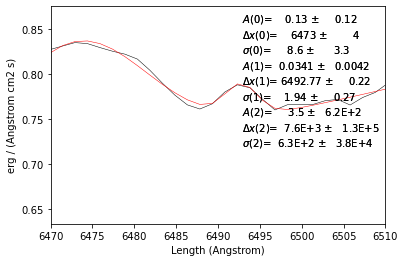

In [37]:
#hbeta fit


sp.plotter(xmin=6470, xmax=6510, linestyle='-')
guesses = [0.83, 6472, 5, 0.8, 6491, 2, 0.77, 6504, 1]
sp.specfit(fittype='gaussian', guesses=guesses, color='r')

In [64]:
integral, error = sp.specfit.integral(direct=False, return_error=True)

ValueError: Spectral axis is not linear to within 1e-08.  cdelt is not well-defined.

In [35]:
sp2 = 

AttributeError: 'Spectrum' object has no attribute 'setfitspec'

In [ ]:
from scipy.integrate import quad
import scipy.integrate as integrate
import numpy as np
import numpy
import random
import math

In [ ]:
def gaussian(sigma,mu, x):
    #===================================================#
    #Define and Compute Gaussian Function with the FWDM #
    #===================================================#   
    FWHM = 2*(np.sqrt(2*np.log(2)))*sigma
    k = 1 / (sigma * math.sqrt(2*math.pi))
    s = -1.0 / (2 * sigma * sigma)
    def f(x):
        return k * math.exp(s * (x - mu)*(x - mu))

    print("The corresponding FHWM", FWHM)
    print("The Integral is", quad(f, -np.inf, np.inf))
    return FWHM

In [32]:
np.min(flux.value)

-8.0655576e-17

In [55]:
components = sp.specfit.get_components()


In [58]:
integral, error = sp.specfit.integral(direct=False, return_error=True)


ValueError: Spectral axis is not linear to within 1e-08.  cdelt is not well-defined.

In [14]:
#open sdss spectra
f = fits.open('sdss_dr17_spectrum.fits')
specdata = f[1].data
f.close()

In [15]:
lamb = 10**specdata['loglam'] * u.AA  # don't use lambda as a variable name! it's a protected python word
flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
inverse_variance = specdata['ivar']  # ivar is the inverse variance, see here: 
# wherever ivar is 0, this is a bad pixel
one_sigma_error = np.sqrt(1 / inverse_variance) * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
uncertainty = StdDevUncertainty(one_sigma_error)
model =  specdata['model'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 


spec = Spectrum1D(spectral_axis=lamb, flux=flux, redshift=0.335, uncertainty=uncertainty)

# mask the spectrum where ivar==0

ivar_mask = inverse_variance == 0
and_mask = specdata['and_mask'] == 1

# bad_pixel_spectrum = spec.flux
# bad_pixel_spectrum[np.logical_not(ivar_mask)] = np.nan
# bad_pixel_spectrum[np.logical_not(and_mask)] = np.nan

spec.flux[ivar_mask] = np.nan
spec.flux[and_mask] = np.nan




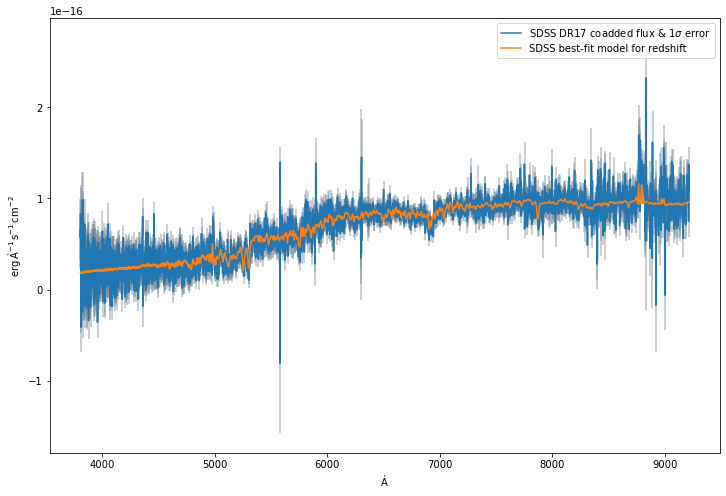

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.step(spec.spectral_axis, spec.flux, label=r'SDSS DR17 coadded flux & 1$\sigma$ error')
ax.errorbar(spec.spectral_axis, spec.flux, yerr=one_sigma_error, zorder=1, color='slategray', alpha=0.5)
ax.plot(spec.spectral_axis, model, label='SDSS best-fit model for redshift')
# ax.plot(spec.spectral_axis, bad_pixel_spectrum, label='SDSS best-fit model for redshift')

ax.legend()

(0.0, 2e-16)

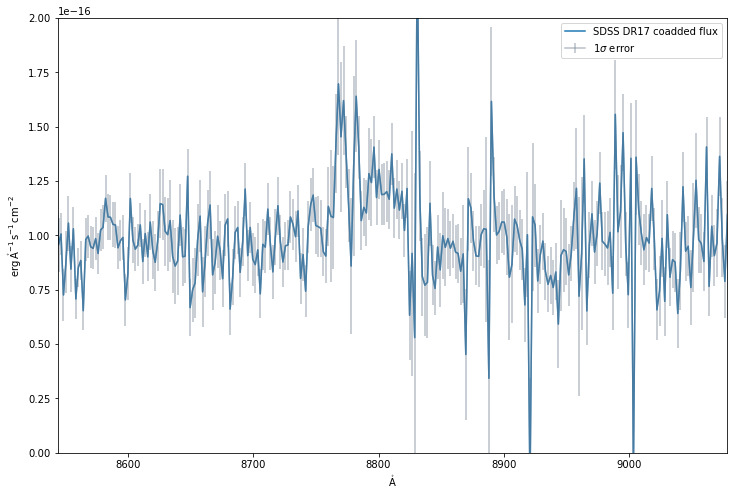

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(spec.spectral_axis, spec.flux, yerr=one_sigma_error, label=r'1$\sigma$ error', color='slategray', alpha=0.5)
ax.plot(spec.spectral_axis, spec.flux, label='SDSS DR17 coadded flux')
# ax.plot(spec.spectral_axis, model, label='SDSS best-fit model for redshift')
# ax.plot(spec.spectral_axis, ivar, label='Inverse variance')


ax.legend()

ax.set_xlim(6400 * (1 + spec.redshift.value), 6800 * (1 + spec.redshift.value))
ax.set_ylim(0, 2e-16)

### 3. SDSS vs ALFOSC

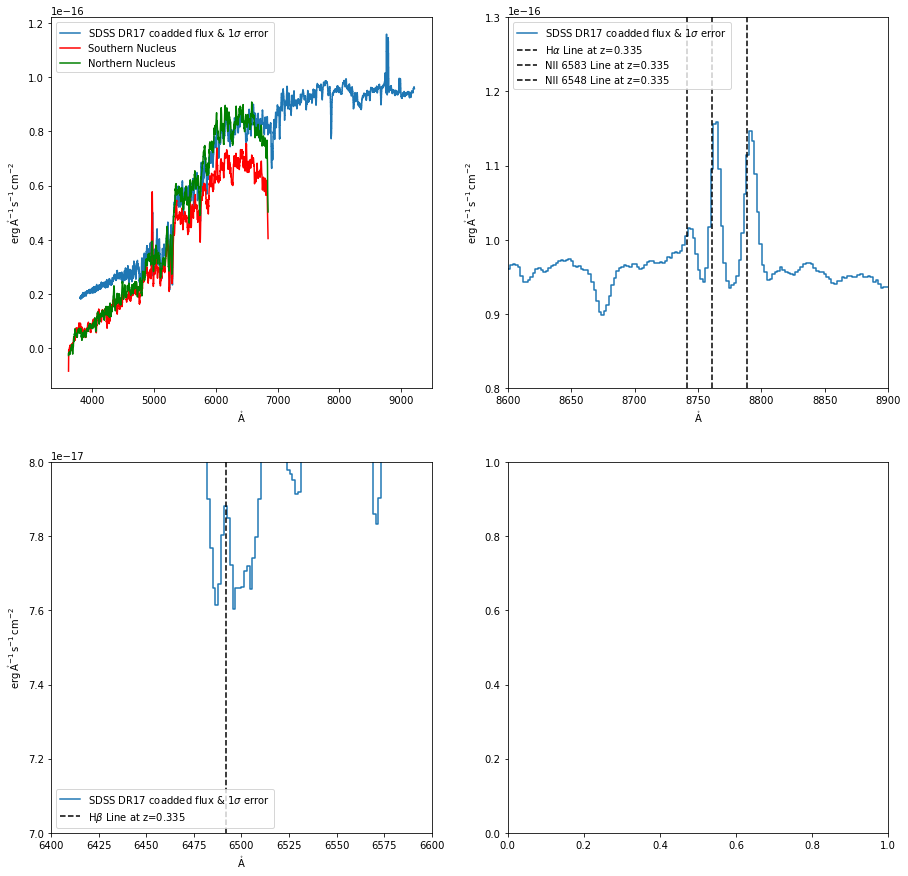

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs.ravel()


ax = axs[0][0]
ax.step(spec.spectral_axis, model, label=r'SDSS DR17 coadded flux & 1$\sigma$ error')
ax.plot(alfosc_wav[0], alfosc_lower.data * 1e-19, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data*1e-19, label ='Northern Nucleus', color='g')

ax.legend()

ax = axs[0][1]
ax.step(spec.spectral_axis, model, label=r'SDSS DR17 coadded flux & 1$\sigma$ error')
ax.set_xlim(8600, 8900)
ax.set_ylim(0.8e-16, 1.3e-16)
ax.axvline(spectral_line_dict['Halpha'] * 1.335, ls = '--', color='k', label = r'H$\alpha$ Line at z=0.335')
ax.axvline(spectral_line_dict['NII 6583'] * 1.335, ls = '--', color='k', label = r'NII 6583 Line at z=0.335')
ax.axvline(spectral_line_dict['NII 6548'] * 1.335, ls = '--', color='k', label = r'NII 6548 Line at z=0.335')

ax.legend()

ax = axs[1][0]
ax.step(spec.spectral_axis, model, label=r'SDSS DR17 coadded flux & 1$\sigma$ error')
ax.set_xlim(6400, 6600)
ax.set_ylim(0.7e-16, 0.8e-16)
ax.axvline(spectral_line_dict['Hbeta'] * 1.335, ls = '--', color='k', label = r'H$\beta$ Line at z=0.335')
# ax.axvline(spectral_line_dict['NII 6583'] * 1.335, ls = '--', color='k', label = r'NII 6583 Line at z=0.335')
# ax.axvline(spectral_line_dict['NII 6548'] * 1.335, ls = '--', color='k', label = r'NII 6548 Line at z=0.335')

ax.legend()


### fit halpha and hbeta line using specutils

In [40]:
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

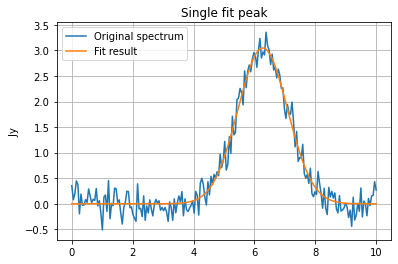

In [41]:
# Create a simple spectrum with a Gaussian.
np.random.seed(0)
x = np.linspace(0., 10., 200)
y = 3 * np.exp(-0.5 * (x- 6.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init = models.Gaussian1D(amplitude=3.*u.Jy, mean=6.1*u.um, stddev=1.*u.um)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(x*u.um)

# Plot the original spectrum and the fitted.
plt.plot(x, y, label="Original spectrum")
plt.plot(x, y_fit, label="Fit result")
plt.title('Single fit peak')
plt.grid(True)
plt.legend()

In [55]:
yh.unit

Unit("erg / (Angstrom cm2 s)")

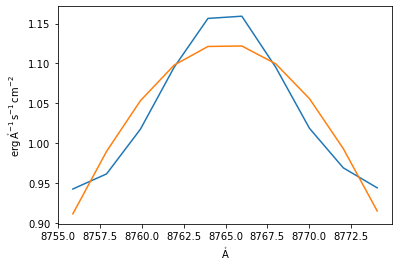

In [79]:
xh, yh = spec.spectral_axis[3620:3630], model[3620:3630]
spectrum = Spectrum1D(flux=yh*1e16, spectral_axis=xh)

# # Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init = models.Gaussian1D(amplitude=1.15*yh.unit, mean=8765*xh.unit, stddev=1*xh.unit)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(xh)
plt.plot(spec.spectral_axis[3620:3630], model[3620:3630]*1e16, label=r'SDSS DR17 coadded flux & 1$\sigma$ error')
plt.plot(xh, y_fit, label="Fit result")
#plt.xlim(8750, 8780)

In [77]:
y_fit

<Quantity [0.90024102, 0.94956135, 0.99272265, 1.02845809, 1.05599826,
           1.07448965, 1.08352017, 1.08282032, 1.07240561, 1.05250631,
           1.02373091, 0.9867045 , 0.94253018, 0.89221745] erg / (Angstrom cm2 s)>

### Compare Spectra in Northern and Southern Nuclei

In [9]:
sdss_path = path_to_beads + 'Analysis/optical_spectra/'
sdss_spectrum_file = sdss_path + 'Nordic_Optical_Telescope_Spectrum/spec/sdss_smoothed.fits'

In [10]:
sdss_spectrum = fits.open(sdss_spectrum_file)[0]

In [14]:
sdss_hdr = sdss_spectrum.header

sdss_wave = []
#https://classic.sdss.org/dr3/products/spectra/read_spSpec.html

for pixel in range(sdss_hdr['NAXIS1']):
    sdss_wave_i = 10**(sdss_hdr['COEFF0'] + (sdss_hdr['COEFF1'] * (pixel))) #in vacuum units https://classic.sdss.org/dr3/products/spectra/vacwavelength.html
    sdss_wave_air_i = sdss_wave_i / (1.0 + 2.735182E-4 + 131.4182 / sdss_wave_i**2 + 2.76249E8 / sdss_wave_i**4)
    sdss_wave.append(sdss_wave_air_i)

In [15]:
alfosc_path = path_to_beads + 'Analysis/optical_spectra/Nordic_Optical_Telescope_Spectrum/spec/'
alfosc_lower_file = alfosc_path  + 'lowerfinal_smoothed10.fits'
alfosc_upper_file = alfosc_path  + 'upperfinal_smooth10.fits'
alfosc_wav_file = alfosc_path  + 'outputwav.txt'


In [16]:
alfosc_lower = fits.open(alfosc_lower_file)[0]
alfosc_upper = fits.open(alfosc_upper_file)[0]
alfosc_wav = pd.read_csv(alfosc_wav_file, header=None, dtype=float)

In [9]:
spectral_line_dict = {
# abs'Ne IV': 2439.5,
#                      'Mg II': 2799.117,   ## Lines blueward of H-delta are just too blue for our wavelength coverage
#                      'Ne V': 3346.79,
#                      'Ne VI': 3426.85,
                     'O II 3727': 3727.092,
#                      'O II 3729': 3729.875,
#                      'He I': 3889.0,
#                      'S II 4072': 4072.3,
                     'Ca II K': 3933,
                     'Ca II H': 3969,
                     'Mg': 5175,
                     'Hgamma$': 4341.68,
                     'Hbeta$': 4862.68,
                     'OIII 4960': 4958.9,
                     'OIII 5007': 5006.84,
                      'OI 6300': 6300.3,
                      'NII 6583': 6583.45,
                      'NII 6548': 6548.05,
                      'SII 6717': 6716.44,
                      'SII 6730': 6730.81,
                      'Halpha': 6562.80,
                     }

In [12]:
spectral_line_dict['Ca II H']

3969

In [ ]:
#By eye guess of the redshift

zn = 0.334
zs = 0.3332

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs.ravel()

ax = axs[0]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(spectral_line_dict['Ca II H'] * 1.335, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
#ax.axvline(mg_obs, ls = '--', color='k', label = r'Mg (5175 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')
# ax.set_xlim(4800, 5500)
ax.set_xlim(5600, 8000)
# ax.set_ylim(180, 650)
ax.set_ylabel("Flux (some units)")
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

ax = axs[1]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(ca2_h, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')
ax.legend()
ax.set_xlim(5200, 5400)
ax.set_ylim(180, 650)
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

### 2. SDSS Spectra

(8600.0, 8900.0)

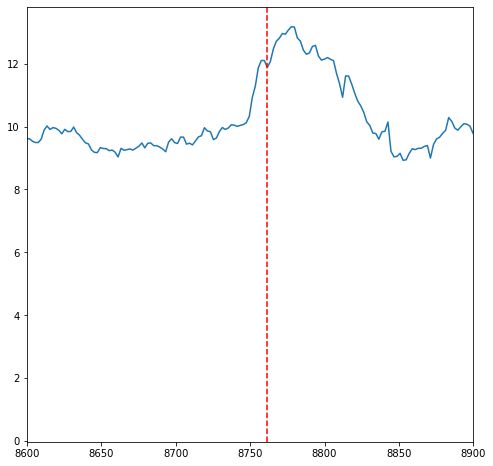

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sdss_wave , sdss_spectrum.data[0], label ='SDSS spec  1 at mag 20.20')
# ax.set_xlim(8600, 9000)
# ax.set_ylim(6,15)
ax.axvline(6562.80 * (1+0.335), ls = '--', color='r', label = 'Ha Line at z=0.335')

ax.axvline(ca2_h, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
ax.axvline(mg_obs, ls = '--', color='k', label = r'Mg (5175 $\dot{A}$) Line at z=0.335')

ax.set_xlim(8600, 8900)

In [25]:
4860 * 1.335

6488.099999999999

(6400.0, 6600.0)

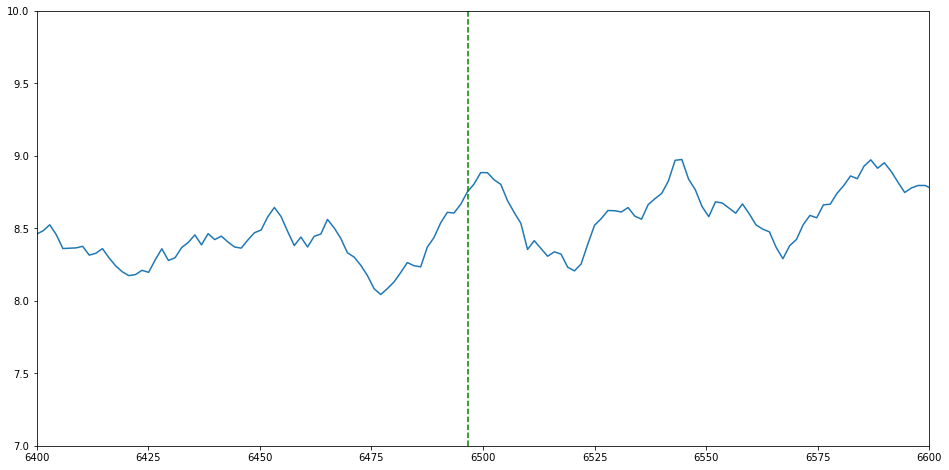

In [39]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(sdss_wave , sdss_spectrum.data[0], label ='SDSS spec  1 at mag 20.20')
# ax.set_xlim(8600, 9000)
ax.set_ylim(7,10)
ax.axvline(6562.80 * (1+0.335), ls = '--', color='r', label = 'Ha Line at z=0.335')
ax.axvline(4862.68 * (1+0.336), ls = '--', color='g', label = 'Hb Line at z=0.335')
ax.axvline(ca2_h, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
ax.axvline(mg_obs, ls = '--', color='k', label = r'Mg (5175 $\dot{A}$) Line at z=0.335')

ax.set_xlim(6400, 6600)

In [ ]:
6525

Text(0.5, 0, 'Observed Wavelength ($\\dot{A}$)')

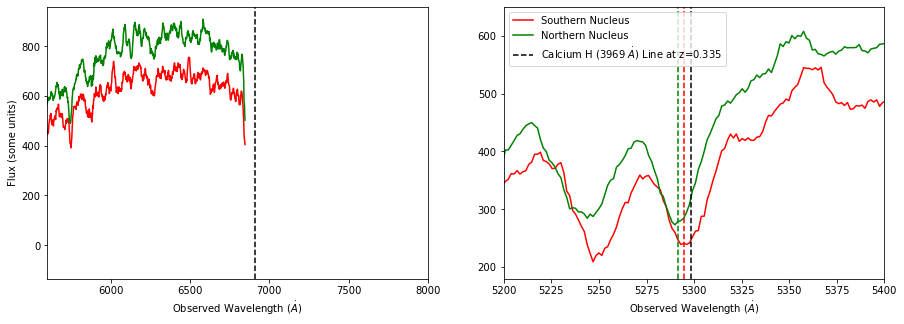

In [13]:
#By eye guess of the redshift

zn = 0.334
zs = 0.3332

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs.ravel()

ax = axs[0]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(ca2_h, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
ax.axvline(mg_obs, ls = '--', color='k', label = r'Mg (5175 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')
# ax.set_xlim(4800, 5500)
ax.set_xlim(5600, 8000)
# ax.set_ylim(180, 650)
ax.set_ylabel("Flux (some units)")
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

ax = axs[1]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(ca2_h, ls = '--', color='k', label = r'Calcium H (3969 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3969 * (1+zn), ls = '--', color='r')
ax.axvline(3969 * (1+zs), ls = '--', color='g')
ax.legend()
ax.set_xlim(5200, 5400)
ax.set_ylim(180, 650)
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

Text(0.5, 0, 'Observed Wavelength ($\\dot{A}$)')

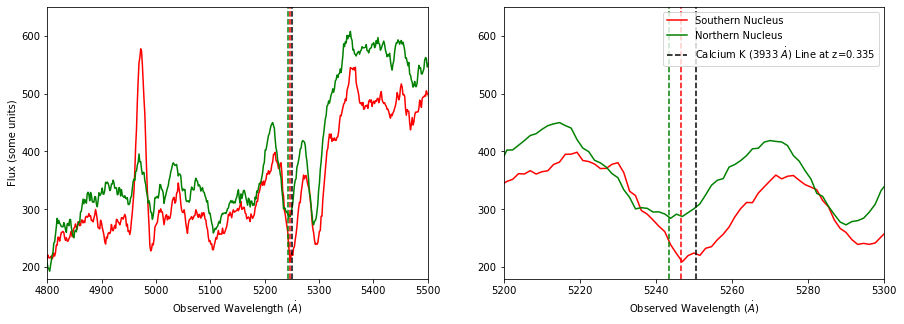

In [37]:
#By eye guess of the redshift

zn = 0.334
zs = 0.3332

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs.ravel()

ax = axs[0]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(ca2_k, ls = '--', color='k', label = r'Calcium K (3933 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3933 * (1+zn), ls = '--', color='r')
ax.axvline(3933 * (1+zs), ls = '--', color='g')
ax.set_xlim(4800, 5500)
ax.set_ylim(180, 650)
ax.set_ylabel("Flux (some units)")
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

ax = axs[1]
ax.plot(alfosc_wav[0], alfosc_lower.data, label ='Southern Nucleus', color='r')
ax.plot(alfosc_wav[0], alfosc_upper.data, label ='Northern Nucleus', color='g')
ax.axvline(ca2_k, ls = '--', color='k', label = r'Calcium K (3933 $\dot{A}$) Line at z=0.335')
# ax.axvline(o2_3727, ls = '--', color='r')
ax.axvline(3933 * (1+zn), ls = '--', color='r')
ax.axvline(3933 * (1+zs), ls = '--', color='g')
ax.legend()
ax.set_xlim(5200, 5300)
ax.set_ylim(180, 650)
ax.set_xlabel(r"Observed Wavelength ($\dot{A}$)")

In [276]:
alfosc_wav[0][1050]

5233.060899

In [50]:
sdss_wave[0]

3792.9462303023815

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


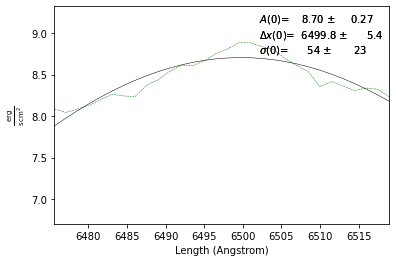

In [79]:
spectrum_range =[6475, 6520]
spectrum_xaxis = np.array(sdss_wave)#* u.AA
ids = np.where((spectrum_xaxis > spectrum_range[0]) & (spectrum_xaxis < spectrum_range[1]))
data_xaxis = spectrum_xaxis[ids]
spectrum = sdss_spectrum.data[0]
data = spectrum[ids]
spectrum_err = np.full(len(data), 1.0) #* (u.erg/u.s/u.cm**2)
units = [u.AA, u.erg/u.s/u.cm**2]
xlabel ='Wavelength'
ylabel='Flux'
guesses= [9, 6500, 8]
xminval, xmaxval = [None, None]

sp = pyspeckit.Spectrum(xarr=data_xaxis, data=data, xarrkwargs={'unit':units[0]}, unit=units[1])

sp.plotter(linestyle='dashed', color='g')
# sp.baseline(subtract=False)
sp.specfit(fittype='gaussian', negamp=False, guesses=guesses, color='k')

# integral, error = sp.specfit.integral(return_error=True)
    

In [80]:
sp.xarr

SpectroscopicAxis([6475.5968140228315,...,6518.982580548503], unit=Unit("Angstrom"), refX=None, refX_unit=None, frame=None, redshift=None, xtype=None, velocity convention=None)

In [71]:
sp.specfit.integral()

ValueError: Spectral axis is not linear to within 1e-08.  cdelt is not well-defined.

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


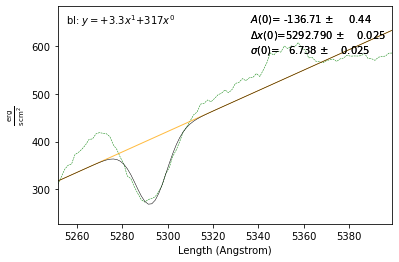

In [32]:
spectrum_range =[5250, 5400]
spectrum_xaxis = alfosc_wav#* u.AA
ids = np.where((spectrum_xaxis[0] > spectrum_range[0]) & (spectrum_xaxis[0] < spectrum_range[1]))
data_xaxis = spectrum_xaxis[0].iloc[ids]
spectrum = alfosc_upper.data 
data = spectrum[ids]
spectrum_err = np.full(len(data), 1.0) #* (u.erg/u.s/u.cm**2)
units = [u.AA, u.erg/u.s/u.cm**2]
xlabel ='Wavelength'
ylabel='Flux'
guesses= [-210, 3969 * (1+zh), 15]
xminval, xmaxval = [None, None]

sp = pyspeckit.Spectrum(xarr=data_xaxis, data=data, xarrkwargs={'unit':units[0]}, unit=units[1])

sp.plotter(linestyle='dashed', color='g')
sp.baseline(subtract=False)
sp.specfit(fittype='gaussian', negamp=True, color='k')



In [19]:
zn = (5292.79/3969) - 1
zn

0.3335323759133282

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


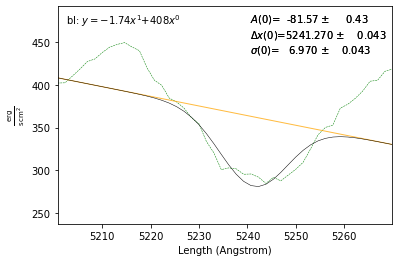

In [33]:
spectrum_range =[5200, 5270]
spectrum_xaxis = alfosc_wav#* u.AA
ids = np.where((spectrum_xaxis[0] > spectrum_range[0]) & (spectrum_xaxis[0] < spectrum_range[1]))
data_xaxis = spectrum_xaxis[0].iloc[ids]
spectrum = alfosc_upper.data 
data = spectrum[ids]
spectrum_err = np.full(len(data), 1.0) #* (u.erg/u.s/u.cm**2)
units = [u.AA, u.erg/u.s/u.cm**2]
xlabel ='Wavelength'
ylabel='Flux'
guesses= [-210, 3933 * (1+zh), 15]
xminval, xmaxval = [None, None]

sp = pyspeckit.Spectrum(xarr=data_xaxis, data=data, xarrkwargs={'unit':units[0]}, unit=units[1])

sp.plotter(linestyle='dashed', color='g')
sp.baseline(subtract=False)
sp.specfit(fittype='gaussian', negamp=True, color='k')



In [60]:
zn2 = (5241.27/3933) - 1
zn2

0.3326392067124333

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


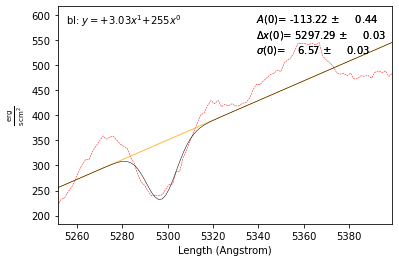

In [38]:
spectrum_range =[5250, 5400]
spectrum_xaxis = alfosc_wav#* u.AA
ids = np.where((spectrum_xaxis[0] > spectrum_range[0]) & (spectrum_xaxis[0] < spectrum_range[1]))
data_xaxis = spectrum_xaxis[0].iloc[ids]
spectrum = alfosc_lower.data 
data = spectrum[ids]
spectrum_err = np.full(len(data), 1.0) #* (u.erg/u.s/u.cm**2)
units = [u.AA, u.erg/u.s/u.cm**2]
xlabel ='Wavelength'
ylabel='Flux'
xminval, xmaxval = [None, None]
sp = pyspeckit.Spectrum(xarr=data_xaxis, data=data, xarrkwargs={'unit':units[0]}, unit=units[1])

sp.plotter(linestyle='dashed', color='r')
sp.baseline(subtract=False)
sp.specfit(fittype='gaussian', negamp=True, color='k')

In [21]:
zs = (5297.29/3969) - 1
zs

0.33466616276140093

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


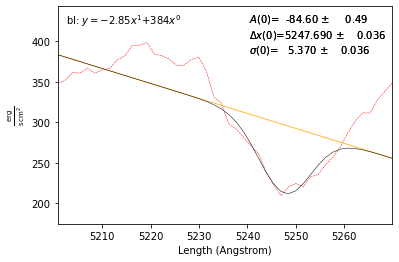

In [39]:
spectrum_range =[5200, 5270]
spectrum_xaxis = alfosc_wav#* u.AA
ids = np.where((spectrum_xaxis[0] > spectrum_range[0]) & (spectrum_xaxis[0] < spectrum_range[1]))
data_xaxis = spectrum_xaxis[0].iloc[ids]
spectrum = alfosc_lower.data 
data = spectrum[ids]
spectrum_err = np.full(len(data), 1.0) #* (u.erg/u.s/u.cm**2)
units = [u.AA, u.erg/u.s/u.cm**2]
xlabel ='Wavelength'
ylabel='Flux'
xminval, xmaxval = [None, None]
sp = pyspeckit.Spectrum(xarr=data_xaxis, data=data, xarrkwargs={'unit':units[0]}, unit=units[1])

sp.plotter(linestyle='dashed', color='r')
sp.baseline(subtract=False)
sp.specfit(fittype='gaussian', negamp=True, color='k')

In [62]:
zs2 = (5247.69/3933) - 1
zs2

0.33427154843630813

In [68]:
np.mean([zn, zn2]), np.mean([zs, zs2])

(0.33308579131288074, 0.33446885559885453)

In [6]:
0.34* const.c.to(u.km/u.s) - 0.328* const.c.to(u.km/u.s)

<Quantity 3597.509496 km / s>

In [67]:
0.3353* const.c.to(u.km/u.s) - 0.3345* const.c.to(u.km/u.s)

<Quantity 239.8339664 km / s>

In [15]:
(0.335* const.c.to(u.km/u.s) + 600 * (u.km/u.s)) - (0.3353* const.c.to(u.km/u.s))

<Quantity 510.0622626 km / s>

In [18]:
(50 * u.kpc /(150 * (u.km/u.s))).to(u.yr)

<Quantity 3.25930741e+08 yr>

In [19]:
(0.335* const.c.to(u.km/u.s) + 600 * (u.km/u.s))/ const.c.to(u.km/u.s)

<Quantity 0.33700138>

### Cluster Redshifts

In [40]:
table_path = machine + 'Analysis/tables/'

In [50]:
galaxies_table = np.loadtxt(table_path + 'apjs380374t4_mrt.txt', skiprows=354, max_rows=17, 
                 dtype={'names': ('telescope', 'cluster', 'label', 'RAh', 'RAm', 'RAs', 'DEd', 'DEm', 'DEs', 'z', 'zclass'),
                     'formats': ('<U16', '<U16', '<U16', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4')})

In [56]:
idg = np.where(galaxies_table['label'] == 'gal')[0]
zgals = galaxies_table['z'][idg]

savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6


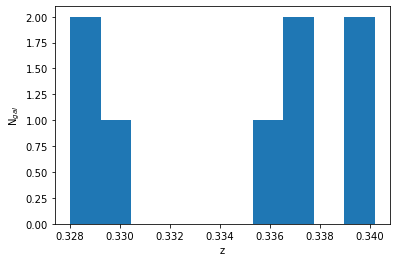

In [58]:
plt.hist(zgals)
plt.xlabel('z')
plt.ylabel('N$_{gal}$')

plt.savefig(fig_path + 'HST_galaxies_z.pdf', overwrite=True)

In [45]:
b11

,0
0,SDSS J0851+3331 A1 08 51 37.108 +33 31 13.5...
1,SDSS J0851+3331 A2 08 51 37.115 +33 31 06.5...
2,SDSS J0851+3331 A3 08 51 39.363 +33 31 27.0...
3,SDSS J0851+3331 B1 08 51 37.987 +33 31 06.8...
4,SDSS J0851+3331 B2 08 51 38.021 +33 31 03.1...
...,...
400,SDSS J2243-0935 gal 22 43 20.718 -09 35 19.8...
401,SDSS J2243-0935 gal 22 43 23.210 -09 35 48.5...
402,SDSS J2243-0935 gal 22 43 19.303 -09 35 54.0...
403,SDSS J2243-0935 gal 22 43 24.131 -09 36 10.5...
